In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import datetime
import numpy as np
import matplotlib.pyplot as plt


from CloudSaturation import CloudSaturation

from Utils import *


In [2]:
#tulip_box = [52.859055, 4.710388, 52.912040, 4.798278]
#tulip_box = [52.981923, 4.577823, 52.762686, 5.224698]
#tulip_box = [52.322227, 4.395521, 52.174074, 4.620172] 
#tulip_box = [52.840049, 5.560622, 52.472093, 6.085825]
#tulip_box = [52.789027, 5.620514, 52.636601, 5.950533]
#tulip_box = [52.930789, 4.719721, 52.800126, 4.865626]
tulip_box = [4.709721, 52.900789, 4.865626, 52.800126, ]

box = CloudSaturation(tulip_box)

In [3]:
%%time
true_color, dates = box.load_tc()
bands, dates = box.load_all_bands()

True color
ALL-BANDS
Bands
Wall time: 5.42 s


In [4]:
# Layers from geopedia that currently work (Also see CloudSaturation.py)
# layers = {'tulip_field_2016':'ttl1904', 'tulip_field_2017':'ttl1905', 'arable_land_2017':'ttl1917'}

# Get dataseries for same region (to reuse cloud data)
field, mask, nonzero = box.get_tulip_mask("tulip_field_2016")
field, mask2016, nonzero = box.get_tulip_mask("tulip_field_2016")
field2, mask2017, nonzero2 = box.get_tulip_mask("tulip_field_2017")

#field3, mask2017, nonzero3 = box.get_tulip_mask("arable_land_2017")
#field3, mask2016, nonzero3 = box.get_tulip_mask("arable_land_2017")

Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1904&height=1120&width=1047&srs=EPSG:3857&bbox=524283.7434983876,6964667.613586511,541639.0087105136,6946111.878701824
Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1904&height=1120&width=1047&srs=EPSG:3857&bbox=524283.7434983876,6964667.613586511,541639.0087105136,6946111.878701824
Downloaded from http://service.geopedia.world/wms/ml_aws?service=WMS&request=GetMap&styles=&format=image%2Fpng&transparent=false&version=1.1.1&layers=ttl1905&height=1120&width=1047&srs=EPSG:3857&bbox=524283.7434983876,6964667.613586511,541639.0087105136,6946111.878701824


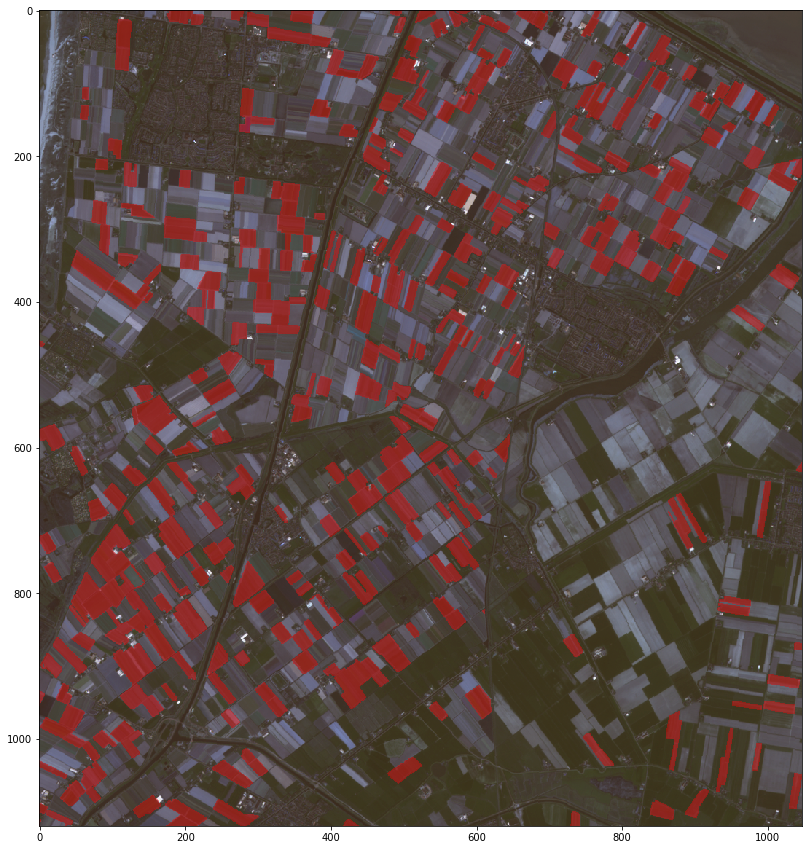

In [5]:
# If mask_maps is not None, for every image in images, each is overlayed with different color
overlay_cloud_mask(true_color[1], [mask2016], mask_maps = [[255, 0, 0]])
#plt.savefig('./ImageRegression/fields.png')

In [6]:
dates

[datetime.datetime(2016, 3, 12, 10, 50, 37),
 datetime.datetime(2016, 4, 11, 10, 50, 25),
 datetime.datetime(2016, 4, 21, 10, 50, 29),
 datetime.datetime(2016, 5, 1, 10, 53, 10),
 datetime.datetime(2016, 5, 11, 10, 53, 43)]

# Prepare data

In [7]:
n = 4 #image number

In [8]:
def ndvi(x):
    return (x[:,7] - x[:,3])/(x[:,7] + x[:,3])

def ndvi_nar(x):
    return (x[:,8] - x[:,3])/(x[:,8] + x[:,3])

def evi(x):
    return 2.5 * (x[:,7] - x[:,4]) / ((x[:,7] + 6.0 * x[:,3] - 7.5 * x[:,1]) + 1.0)

L = 0.5
def savi(x):
    return (x[:,7] - x[:,3]) / (x[:,7] + x[:,3] + L) * (1.0 + L)

def gvi(x):
    return -0.2848 * x[:,1] - 0.2435 * x[:,2] - 0.5436 * x[:,3] + 0.7243 * x[:,7] + 0.084 * x[:,11] - 0.18 *x[:,12]


In [9]:
y = np.array([]) #tulip
x = np.array([]) #bands in array

y = mask.flatten()
y_2016 = mask2016.flatten()
y_2017 = mask2017.flatten()

x = bands[-1][:,:].flatten().reshape(mask.shape[0]*mask.shape[1], 13)

def flaten_all_im(index_list):
    index_flat = []
    for i in range(len(index_list)):
        index = index_list[i].flatten()
        index_flat.append(index)
    #print(index_flat)
    return index_flat

In [10]:
x1 = np.zeros((x.shape[0],x.shape[1]+3))
x1[:,:13] = x
x1[:,13] = ndvi(x)
x1[:,14] = savi(x)
x1[:,15] = evi(x)

In [11]:
X = x1[:,:] #bands used for regression

In [12]:
m = 2*int(X.shape[0]/3)

# Sklearn

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron

In [14]:
import time
from sklearn.metrics import recall_score, precision_score, f1_score

In [15]:
list_of_regressors = [
    LogisticRegression(solver = 'liblinear'),
    DecisionTreeClassifier(),
    MLPClassifier(),
    RandomForestClassifier(n_estimators = 10),
    KNeighborsClassifier(),
    Perceptron(),
    Perceptron(penalty=None, alpha=0.0001, fit_intercept=True,
                 max_iter=1000, tol=1e-3, shuffle=True, verbose=0, eta0=1.0,
                 n_jobs=1, random_state=0, class_weight=None,
                 warm_start=False),
    PassiveAggressiveClassifier()
]

In [16]:
#regressor = LogisticRegression(class_weight = 'balanced', C = 18, tol = 0.02);
regressor = LogisticRegression(solver = 'liblinear');
regressor = DecisionTreeClassifier();
#regressor = MLPClassifier();
#regressor = RandomForestClassifier(n_estimators = 10);
#regressor = KNeighborsClassifier()
#regressor = Perceptron()
regressor1 = Perceptron(penalty=None, alpha=0.0001, fit_intercept=True,
                 max_iter=1000, tol=1e-3, shuffle=True, verbose=0, eta0=1.0,
                 n_jobs=1, random_state=0, class_weight=None,
                 warm_start=False)
#regressor = PassiveAggressiveClassifier()

In [17]:
#predicted = cross_val_predict(regressor, X, y, cv = 3);

In [18]:
#print('F1=', f1_score(y, predicted), 'Recall= ', recall_score(y, predicted),'Precision= ', precision_score(y, predicted))

In [19]:
#to image
#predicted.shape = mask2016.shape

In [20]:
start = time.time() 
regressor.fit(X[0:m],y[0:m])
end = time.time()

print(end - start)

predict = regressor.predict(X[m:])
print('F1=', f1_score(y[m:], predict), 'Recall= ', recall_score(y[m:], predict),'Precision= ',precision_score(y[m:], predict))

22.484100580215454
F1= 0.7117092630748323 Recall=  0.74082794874603 Precision=  0.6847930621404107


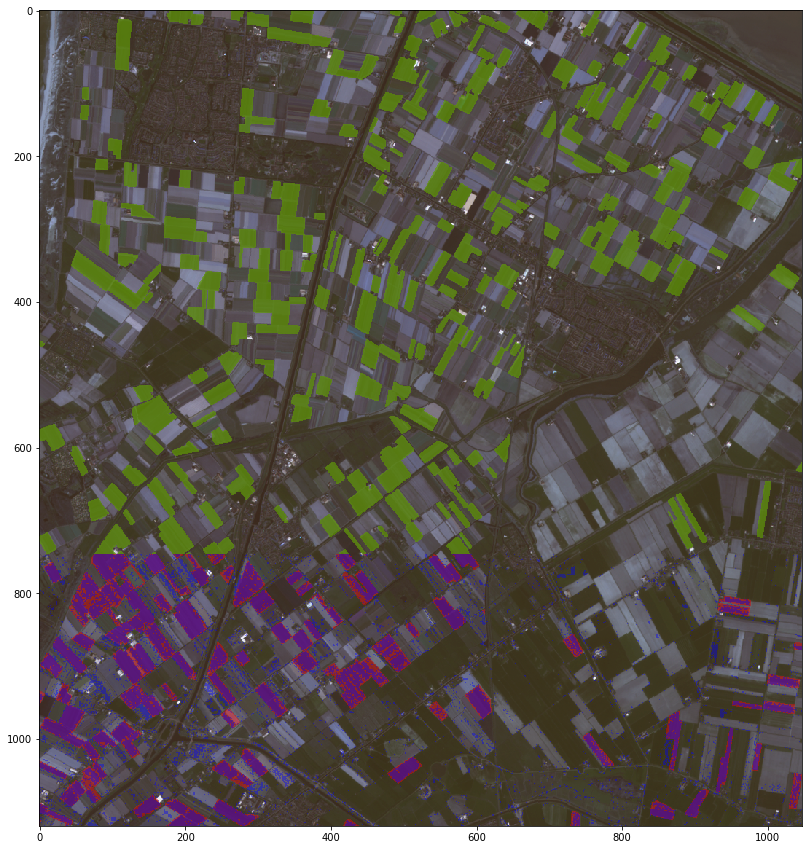

In [21]:
predict_ = np.append(np.zeros(m), predict)
predict_.shape = mask.shape

mask_ = np.append(y_2016[0:m], np.zeros(len(y_2016)-m))
mask_.shape = mask.shape

overlay_cloud_mask(true_color[1], [mask2016, mask_, predict_], mask_maps = [[255, 0, 0],[0, 255, 0], [0, 0, 255]])
plt.savefig('./graphs/' + 'decision_tree', bbox_inches="tight", dpi=300)
plt.show()

# Skmultiflow

In [22]:
from skmultiflow.trees.hoeffding_tree import HoeffdingTree
from skmultiflow.lazy.knn import KNN
from skmultiflow.meta.adaptive_random_forests import ARFBaseLearner, AdaptiveRandomForest
from skmultiflow.neural_networks.perceptron import PerceptronMask

In [23]:
from skmultiflow.drift_detection import PageHinkley

In [24]:
ht = HoeffdingTree()
knn = KNN()
arf = ARFBaseLearner(index_original = 10,
                     classifier = ht,
                     instances_seen = 2,
                     drift_detection_method = PageHinkley(),
                     warning_detection_method = PageHinkley(),
                     is_background_learner = True
                    )
arf2 = AdaptiveRandomForest()
percep = PerceptronMask()

reg = ht

start = time.time() 
#reg.partial_fit(X[0:m],y[0:m], weight=None, instances_seen=None )
reg.partial_fit(X[0:m],y[0:m])
#reg.fit(X[0:m],y[0:m])
end = time.time()

print(end - start)

predict = reg.predict(X[m:])
print('F1= ', f1_score(y[m:], predict), 'Recall= ', recall_score(y[m:], predict), 'Precision= ', precision_score(y[m:], predict))


194.1399586200714
F1=  0.768505478480608 Recall=  0.7022049428686161 Precision=  0.8486312399355878


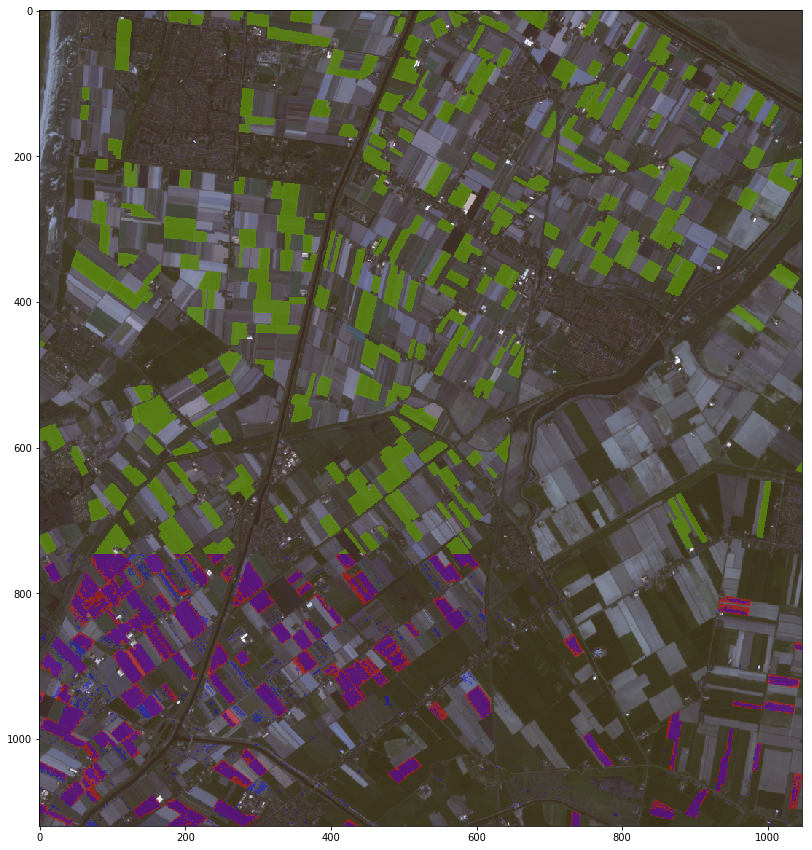

In [25]:
predict_ = np.append(np.zeros(m), predict)
predict_.shape = mask.shape

mask_ = np.append(y_2016[0:m], np.zeros(len(y_2016)-m))
mask_.shape = mask.shape

overlay_cloud_mask(true_color[1], [mask2016, mask_, predict_], mask_maps = [[255, 0, 0],[0, 255, 0], [0, 0, 255]])
plt.savefig('./graphs/' + 'hoeffding', bbox_inches="tight", dpi=300)
plt.show()

In [21]:
from skmultiflow.data.data_stream import DataStream
stream = DataStream(X,y)
stream.prepare_for_use()

#print(stream.next_sample()[0])

In [22]:
m

781760

In [ ]:
%%time

ht = HoeffdingTree()
knn = KNN()
arf = AdaptiveRandomForest(n_estimators = 10, max_features=10)
percep = PerceptronMask()

reg = arf

stream = DataStream(X,y)
stream.prepare_for_use()

start = time.time()
for i in range(m):
    if i % 10000 == 0:
        print(i)
    z = stream.next_sample()
    #reg.partial_fit(z[0], z[1], weight=None, instances_seen=None )
    reg.partial_fit(z[0], z[1])
    #reg.fit(X[0:m],y[0:m])

end = time.time()

print(end - start)

predict = reg.predict(X[m:])
print('F1= ', f1_score(y[m:], predict), 'Recall= ', recall_score(y[m:], predict), 'Precision= ',precision_score(y[m:], predict))


In [39]:
%%time
predict = reg.predict(X[m:    ])
print('F1= ', f1_score(y[m:    ], predict), 'Recall= ', recall_score(y[m:    ], predict), 'Precision= ',precision_score(y[m:    ], predict))

F1=  0.4703275467808946 Recall=  0.6663746212536049 Precision=  0.3634119391990762
Wall time: 5min 36s


In [40]:
len(y[m:])

390880

In [38]:
%%time
k=130000
ht = HoeffdingTree()
knn = KNN()
arf = ARFBaseLearner(index_original = 10,
                     classifier = ht,
                     instances_seen = 2,
                     drift_detection_method = PageHinkley(),
                     warning_detection_method = PageHinkley(),
                     is_background_learner = True
                    )
arf2 = AdaptiveRandomForest(n_estimators = 10, max_features=50)
percep = PerceptronMask()

reg = arf2

stream = DataStream(X,y)
stream.prepare_for_use()

start = time.time()
for i in range(k):
    if i % 1000 == 0:
        print('',i)
        print(time.time() - start)
    z = stream.next_sample()
    #reg.partial_fit(z[0], z[1], weight=None, instances_seen=None )
    reg.partial_fit(z[0], z[1])
    #reg.fit(X[0:m],y[0:m])

end = time.time()

print(end - start)

predict = reg.predict(X[k:k+3000])
print('F1= ', f1_score(y[k:k+3000], predict), 'Recall= ', recall_score(y[k:k+3000], predict), 'Precision= ',precision_score(y[k:k+3000], predict))

 0
0.006618022918701172
 1000
8.606407880783081
 2000
17.2300922870636
 3000
25.800230979919434
 4000
35.21034097671509
 5000
45.32025098800659
 6000
55.336203813552856
 7000
64.91624760627747
 8000
74.18636131286621
 9000
82.12618780136108
 10000
90.43972206115723
 11000
98.40643095970154
 12000
107.38012361526489
 13000
116.52619624137878
 14000
125.75003933906555
 15000
134.870103597641
 16000
143.6690971851349
 17000
153.18966555595398
 18000
162.08631491661072
 19000
170.39985489845276
 20000
178.66605472564697
 21000
187.80875039100647
 22000
196.96999597549438
 23000
205.70614385604858
 24000
215.19610452651978
 25000
223.34511804580688
 26000
231.70646572113037
 27000
239.77964997291565
 28000
247.90973663330078
 29000
255.75003361701965
 30000
263.8202407360077
 31000
271.08056139945984
 32000
279.4900846481323
 33000
287.6962878704071
 34000
295.7102975845337
 35000
303.0062348842621
 36000
309.8398611545563
 37000
316.95615434646606
 38000
324.4366614818573
 39000
332.636082

In [258]:
predict+y[k:k+3000]

array([0, 0, 0, ..., 0, 0, 0])

In [261]:
g=0
for  i in predict+y[k:k+3000]:
    if i == 2:
        g+=1
print(g)

5


In [260]:
g=0
for  i in predict:
    if i == 1:
        g+=1
print(g)

5
